In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import chisquare, norm, combine_pvalues
from IPython.display import display, Markdown
from tqdm import tqdm

In [2]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Normal Dispersal Kernel Test

In [3]:
def test_normal_dispersal_kernel(
    algorithm, speciation=0.001, seeds=[42], sample=1.0, radius=0, sigma=100.0,
):
    total_pvalues_x = []
    total_pvalues_y = []
    total_location_deltas = []
    
    sigma_3 = int(3*sigma)
    step = int(max(sigma_3*2 / 100, 1))
    
    cdf = norm(loc=0.0, scale=sigma).cdf
    
    expected_freq = np.array([cdf(np.round(x) + step - 0.5) - cdf(np.round(x) - 0.5) for x in range(-sigma_3, sigma_3+1, step)])
    
    for seed in seeds:
        # Configure the simulation
        config = "".join("""
        (
            speciation: {speciation},
            seed: {seed},
            sample: {sample},

            algorithm: {algorithm}(),

            scenario: AlmostInfinite(
                radius: {radius},
                sigma: {sigma},
            ),

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                    reporters: [
                        GlobalCoverage(output: "{output_file}"),
                    ],
                ),
            ],
        )
        """.format(
            target_directory=target_directory, output_file="/dev/fd/2",
            algorithm=algorithm, speciation=speciation, seed=seed, sample=sample,
            radius=radius, sigma=sigma,
        ).split()).replace(",)", ")").replace(",]", "]")

        # Run the simulation
        locations_io = StringIO(subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
        ), check=True, capture_output=True, text=True).stderr)

        # Read in the dispersal locations
        location_deltas = []
        with locations_io:
            reader = csv.reader(locations_io)
            next(reader)

            for row in reader:
                location_deltas.append((int(row[3]) - int(row[0]), int(row[4]) - int(row[1])))
        location_deltas = np.array(location_deltas)

        hist_x = np.histogram(location_deltas[:,0], bins=[x - 0.5 for x in range(-sigma_3, sigma_3+1+step, step)])[0]
        hist_y = np.histogram(location_deltas[:,1], bins=[x - 0.5 for x in range(-sigma_3, sigma_3+1+step, step)])[0]
        
        # Calculate the goodness of fit of the dispersal kernel
        gof_x = chisquare(hist_x, expected_freq * len(location_deltas))
        gof_y = chisquare(hist_y, expected_freq * len(location_deltas))
        
        total_pvalues_x.append(gof_x.pvalue)
        total_pvalues_y.append(gof_y.pvalue)
        total_location_deltas.append(location_deltas)
    
    gof_x_statistic, gof_x_pvalue = combine_pvalues(total_pvalues_x)
    gof_y_statistic, gof_y_pvalue = combine_pvalues(total_pvalues_y)
    
    if gof_x_pvalue <= 0.01 or gof_x_pvalue >= 0.99 or gof_y_pvalue <= 0.01 or gof_y_pvalue >= 0.99:
        display(Markdown(f"## <span style='color:purple'><u>{algorithm}</u></span>"))
    elif gof_x_pvalue <= 0.05 or gof_x_pvalue >= 0.95 or gof_y_pvalue <= 0.05 or gof_y_pvalue >= 0.95:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof_x_pvalue <= 0.1 or gof_x_pvalue >= 0.9 or gof_y_pvalue <= 0.1 or gof_y_pvalue >= 0.9:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
        
    display(Markdown("#### Fisher’s combined Chi-squared test:"))
    display(Markdown(f"* x-axis p-value: {gof_x_pvalue}\n* x-axis statistic: {gof_x_statistic}"))
    display(Markdown(f"* y-axis p-value: {gof_y_pvalue}\n* y-axis statistic: {gof_y_statistic}"))
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title("Distribution of x-axis p-values")
    ax1.set_xlabel("p")
    ax1.set_ylabel("pdf")
    ax1.hist(total_pvalues_x, density=True)
    ax2.set_title("Distribution of y-axis p-values")
    ax2.set_xlabel("p")
    ax2.set_ylabel("pdf")
    ax2.hist(total_pvalues_y, density=True)
    plt.show()
    
    display(Markdown("#### Dispersal Histograms:"))
    
    location_deltas = np.concatenate(total_location_deltas)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    ax1.set_title("Per-generation relative dispersal")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    hist1 = ax1.hist2d(location_deltas[:,0], location_deltas[:,1], bins=(range(-sigma_3, sigma_3+1, step), range(-sigma_3, sigma_3+1, step)), density=True)
    fig.colorbar(hist1[3], ax=ax1)
    
    x = np.linspace(-sigma_3, sigma_3, 2*sigma_3 + 1)
    p = norm.pdf(x, loc=0.0, scale=sigma)
    
    ax2.set_title("Dispersal histogram x")
    ax2.set_xlabel("x")
    ax2.set_ylabel("pmf")
    ax2.plot(x, p, color='red', linewidth=2, alpha=0.5, label=f"expected: mu=0.0 sigma={sigma}")
    loc, scale = norm.fit(location_deltas[:,0])
    ax2.hist(location_deltas[:,0], bins=range(-sigma_3, sigma_3+1), density=True, label=f"observed: mu≈{round(loc, 3)} sigma≈{round(scale, 3)}")
    ax2.legend()
    ax2.legend(loc='lower center')
    
    ax3.set_title("Dispersal histogram y")
    ax3.set_xlabel("y")
    ax3.set_ylabel("pmf")
    ax3.plot(x, p, color='red', linewidth=2, alpha=0.5, label=f"expected: mu=0.0 sigma={sigma}")
    loc, scale = norm.fit(location_deltas[:,1])
    ax3.hist(location_deltas[:,1], bins=range(-sigma_3, sigma_3+1), density=True, label=f"observed: mu≈{round(loc, 3)} sigma≈{round(scale, 3)}")
    ax3.legend(loc='lower center')
    
    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seeds: {seeds}"))
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

## <span style='color:green'>Classical</span>

#### Fisher’s combined Chi-squared test:

* x-axis p-value: 0.5555113115109305
* x-axis statistic: 1990.519104106795

* y-axis p-value: 0.3747874202966435
* y-axis statistic: 2019.5854102168153

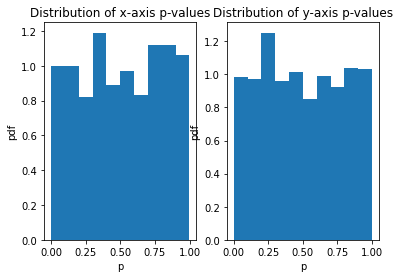

#### Dispersal Histograms:

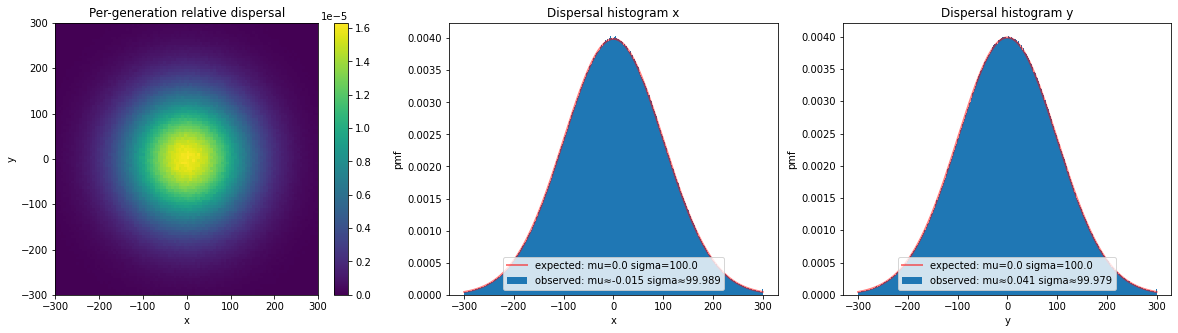

#### Parameters:
* seeds: [10057100021730885714  1785387516861404029 16501249454067311097
  3217336885276342665  6511209657478275003 17487066357988368890
   228751749365951690 17752575839021761982 14591607587667511619
  6252390123329343714  6793785572622825310 11021026285223529985
 14587718297770721414 15742928105703306660 14028170844508379674
 17913302856582335418 17058691068279355617  4547990448990881047
 16299020439528030685 11966722429772478340 17538531463336397218
  3006931552009865681 11027150927926843070  1994264522481351004
 17971962835268772360  5755497781602496677  5779447766022735506
  5903552012153261081 13176941453506285653  4427036898001201634
 15940748309304926853  1489562134369977397 10449026318837013018
 10284348036101283281   437911543875430333 13630010146559252297
 17638794368465044681 15967376834546956157 11001319581793807182
  4289954863685819870 16808366778726168201  5519023668918668625
   327924278627200671  4557772288043502884 12065005527244493087
  6796171105427264718   298852402304373974  4442577763573284859
  5238394056652080762  5433149648932541143  8554629285709302114
 10730698260904155710 17648109932188245920  3430029927790706184
  8053867989839634095 11752821131866439557 13692095515620051733
 11607052231553842540 15210867250255762465  6001453466864800175
  4384224952396392627 14283660712433725716 12385254720819866295
  7882394926620437335 10994010811175550918 11844173000847600944
 18322613812313715861  2900523967629693422  5365886761474634847
  5629567485848758241  6565017674937178131  1145127245793643608
 13358134362236286463 10556307260594317784   520952182143038403
  1137304192611181820  1726107880895798353  3320594049559738316
  7021874567262646861  3297687656207048320 11661065201728319821
  4263433013574209564  4575999137429393167 13703826950968633719
  8163245967546991442 12136329598826608505  4893344424026390722
  5566688666043039922  6209736516863405466 15896112545600735602
  7442383157777527175  4365272023302652667  9003252526110130230
 14050728655289221110 16453016748789080217  3407604404081621600
  7404208260616102382 11165500549869350318 10960115011593745889
 14676706002740494663 15413169412934405301 12327539033329222628
  5748791783650899859  5297158308030210954  7862350811664745319
 14698072816263324285  6314144961144753046 12871321490720726177
 13612099921914299918 10916299308974252831 10927878087289269963
 17509151972730417081 12685385484303146759  1612794838126856328
  3632459171198392600  4752508948995089359  8114083726188203937
 16216393933515401105 12361759769905743819  9134363773834487540
  8804837775580703525  6231888240564618852 17302427936850402612
  3521608044687984788 11806295843826129083  5639597190960327351
 12178284764419800565  1266743075972581347 14603532637987388269
  3553139480195693037  4851486659472492534   261540633629940012
  1941939407810152542  3434723041567466298 15399324310436109442
  1940504319856479477  4106916063756098295  4073670031491697857
  4948633857039886522 11039882417496543691 17676040714327667632
 17343896338273805420   175114048311058018  9724420539995970682
 15694759767125658614  4740940693172922110  8912485448457278974
  1888833417213613271  1444336436531772655 10659106510974682582
   989289129124285586  5241665270044157488 16748992585809258068
 11420939573386244564 16424192742687302409 16835269853444972689
  3108911830517672264    62372818371870125   717611083714402240
 18417068873243798549  8374550552646398211  6438494119433350711
  8894389265837650996  1966485767530890046 13419810608246336676
  3077046247547850041  4563833006352239202 11295052904115969703
  5967110391778380134  5281834332117261534  9397408831371334524
 16840730550833717333  8246719489173927380  5083403029658198582
  9490927677032932156 10710993082206661966 17326796377789437995
 17025648100111056074 15376139687166578648  9812448344914703355
  8490596318042265980    51531454278444715  5967553535943643834
 15392637266990726569   281200866806363687  6216025612888072020
  1993962713602531109  1551067081900633581   224663573240058385
  3844013240955613677  2454839613079475035 13706895557611941367
  5998888573860010924 11924667759438414855 16138292421417615739
 15667323094475574065 13842100990339593014  3412370967323989667
  8051241331397723561 10483370996859335967  4303565767547608421
  9472986830574749955  8373924134631501807 10446039131018942603
 11765706975666973236 12527480472813523866 16373783784440935859
  4837162770958714493  4778777373545402638 10674989884038976460
  2448000089504986917 10567216561339214118  9436458159936678873
  4455964120714993904 10359511611343645196  1252171646865939470
 15638835913865867042  5756096791253956140  4847936229926685628
  5267248926278283311 18169966357436540000  4733929518743927558
 13849939919053074578 10532012477205557968  2245063965387735503
  6584679705106946817  1580658834832343893 12260332719676390557
  2076672559269371674 13377766379256508629  7097332789796507331
  3928516910176835223  4605500117518849578  5922582643798709422
 17721901111415733333 13958856517806645652  8470826828178098530
  8606383279674577586 17352539168162896177  6834434339010088610
  4888182437171539626   941038016559368543 15827084899929134791
 15227478090500193981 16164137727731257730   309759924116539834
   316934286495801836 17759149850509169828  2760547179570656174
 16679182653002676655  3016621077508107113  3694164748036927758
  1376468268632402106 15929756213303836490  1105546243515987517
 14402898620161428698 16508776781993516131   663754363517787372
  7062717973771117275 17405188969763858733 13037618529908086225
 14479134891154972821 10566109951963364999  3847678800794023437
  3422464580318257817  2168958070600100538  4901258464780405369
   466172368280100412 14363662729728044382  1172828625410483392
  5400352558808514148  1774824611116365574 13576795935359892730
 17565545979583379026  3643607422457118056  4646292078747589398
    18033289542164808  8066989136590305813   395673567359494380
  7684382438208350003  2804987712092132472 14302582652516254398
   281313530888825285  7100998789267627521  6066678120436303190
   920629725514251159  9161992292139896001 17673496137790870030
 14382667277427287760   809059357076558573 13847789563919641713
 13170178876769342841  9875228131375951903  8638284877513337214
  2110816495420096926 18260746790890034236   660335180497016441
 18210414307787259225  6212753516822301235 13636731300372559565
 18182899152369669821  4968894528947586375 12027587534695476060
  4710968894496217314 17980513197877258010  5444052233839084250
  4352789999435288630 17967802250741247524 17790345619667236536
 15009610621121553183 16196513771155337623 15301717609284538232
 14982751625303817496 15972911935679678031  9334938966220311312
  2985091294346070172  7026229366181033326  6522211068612073968
 17928356267278158341 12777593222611611001  8432835722643981883
 16598501012196061152  3634072327592665389 15437098035602444497
  8559228061438961704  4606813909071211700  1366186603109575975
 10844816133948696650  2067017545683065062 17910440276497237283
  3263582116904615674 15207689994715556430 13883031822971217412
 13854729346720020215 17545318453091004452 11909801631798028680
 13349172297394638726  9916433452042537392 10655343214759958691
 15684676749937483195  7006925558191033123  6271514995262406906
 17510676578504136104   517887694674853895  3740387411867343372
 17904161911293438454  2526879108757941406  5690561223657222112
  7764800263310448211 13267290532806084980 13317496538712242397
 12043965080451559953  4570561470321755516   892882721219414607
  4835572741865985268  1825459421262601875 16566269848351973991
  9005403819334116815 11709616867137451965 15469221853943166700
 13648952986701670460  8040708528558054023 12310235642650359801
   260320858686354202  5476635149889301063 15387302760149493448
 18097508114478985168  4377096927108284009 16080897656832254998
  8603143243449008858  1451099358084823730 11686672833447074771
  9167441300715517901 12689023270889523321  7981010051592531105
   758793691109724076  2389061125923098366  4325502270448080355
   147010941123521279  4844727360994882611   421459418256974508
  6100654083145803817  8510196315245074074 15213354884857986015
 13524747794882430356 18379756435412547374  1751825451325242558
   245406905537549429  3892766744383916446  9811297153467485061
  4373977618058992422 12511875667523786626 14544474909181063506
 16420778550395952869  4237004850307023732 15135026886521565510
  4005380604077017932 10176816742131390332 11591857733471884147
  8602421973451785386 16091546883928322310  8737473877646530302
 18187132142858798017 13900092296079308001 12970656290647918813
  5690689850088195198 10670619421182599528 10333821527683306249
 14748950994922147333 11978988413585074061    99967297455956075
  1736664238519705066  8995725953343625655  8235094341522776667
 13679540250545831250  2790946517261901223  6631999775509648786
 18185195353638853374 12155198890343058057  4251866078873761445
 17081212944593861359  5740330415129244932 13377944270366928236
  8784240973656906343 12190121166211316885  4976375421264539317
 14284715803631987769 14978017099838727629 14719501182774794660
  2854342399941632078  7569103287320740829 15573780079231936112
 16662571143773228151 16465168444658232667 11940771215046255825
  2701484911647561488 10457931432715851243 12455683534203981135
  6634180382842468572  4590579387685662491 11338023895199683077
 12949801958734882302  7006140196240982303  2929007108662594999
  4833826336298731451  4673626978455857339 14639560258206439628
 17667187410148781404 15459585394789516560  7028665738991881201
  3275638008243276576 12952486120726567448 15483369710781944887
  3659137602670304858  1153495380301535677  2806919755212466395
  4297732800696702035  6246637049305455371 12128709631877132666
  5553985813672986021  3947715484466303819 15318077916494931514
  9414114591679512255 13333429870168339855  6723491819464817082
 16599985178003250260  5688016271933332519 17478795855554071351
  2476844077260461941  4598199279051662856 12238533220542930140
  6087802328408910508  7796114239501739074  7674534853749181098
 10848846677331323002  3886009792398940496   364049887040618188
   439887385577336405  9666598238351276562  1280525631934263053
 16064931032782331603  2420452306546953109 11628974464911531151
   423294364899460005  4936381136835174447 11567815921401072587
 10997031537866692820 15481288852145445690  1493368310725147151
  5813954731447882825  1592231968837181032  4326632550099816806
  2941572971502493268 17096146813670443182  5931523528192534711
  6208435866662199002  9986583179189829479  9975835220408042613
   783534976218753446  1661383827801589704  8933752122350533740
 11716219688832414116 15195352238564992340  1265608865873260711
  5134627323647030851 16079638004740640125  8554093713526414631
  3772865750619455741 17041026959675936343  8198786696499294147
 14093445149616354085 13397319330714015026 12824324488976343569
  9096548594449076005 15832852827283638971 17444683715663380532
  9798765573670860414 11410239475373452031 12101498020574757558
 14322915066406783315 14603465089832766654 18339092614035137849
   855117908509491819 16629681064898638897  5637262170429167354
   164230912710042018 10979755316682610635  9657140261927536082
  3759951017280559797  4362681081825455426 10328288207900139830
  6562179276832912136  4088722453087910376  6385999773062265811
   441184303546752737 16129613937459337241  2738542139165651638
  3479385851430076481 18260862267411033687  3463925002898506892
  9788094926766374158  8431669508592079438 18445249207227321417
  5010969263246998684 13925054484727385013 14740248042573272806
  2867586965206393615  2502503935649749159  6693076370254169883
 16687210644846822418  5143902547593143307  5677929943537697810
  6726180529451979623 16827966901712132608  8604808416557156818
  5183442204219418736  3771564677169561308 15899381566860206456
  5697792911735782774  5894131512104080874 10275121607449444769
  4683246590105558544  1967043807061103489  5920453986447358548
  2669297836869014576  5757984973318348920  4622730702321112057
 17369333131154464511 13533976987808985629  6740590845282178116
  5138526415440441433 11542636084280239891  7542408457905799893
 16760272609194323283 10721650175191566483  4316400603697651273
 14269302220308810096 15993601725669793823  1033425160851629830
  9202992488725553903  8080286560489317621  4857414995526266922
  5906049040922062862 18160790870202306165 10211475334981034389
 16602312361919082180 13889574731277931489 17538679941518609080
  1682559422745071776  1479641095612231063 12456589949404865172
 13963074613004671316 10030586674488873920 15976715453141604162
  6094709987265610093  5681578531348420115  2357965793816836110
   501210540317557907 10772122487904577318 10432209187597698300
  4226895101972118912 18051048717006897393 12688963864174377657
  8261787660337484799  6360793817621373313  9159444899021157018
 12411681148591630456 13699932527586940813 15188572830426278741
  5072202619656455865 13907083492074155435  5349584530634152698
 16366725538510719300 10644407116003041098 18061056194336046550
 10880586450140544335  4445531722335590116  7565839385723142488
 11396841180650565575  1012689801237286593 13142815791856930013
   667968761109384240 14515240380125369030  8402539658299918579
  1799193026301394836  2684276763430512742  3432485293346967701
  7181278185156200954  3985418190385306707 16730173685189397422
 18159479291957644290  8278465815271924971 17137287742113662118
  3381641146318051852  9909462980704061311  2724684445284981652
  3562782624991961171  4041342857066457470 13512279570697113926
  4652726805995702481 14032352417396658043   912885311653790412
  2868060614168054291 12800196940225438996 12994981396773499180
 11834234086001176717  1027991199143403724  5332073329469168324
 11378721002203813587  1582536505531291235 17605531493970462376
 14722615017492708356  1257073802096005455  3716395782128210693
 12965221503700559361   912915972479305840 17632813142926592735
  2520926864715514352   925700515053663460 11373131753631952521
 12399785567604360642  9259209388499592271 17102096223797895965
  8130893553343011889  6778810563921415940 15432353758701094708
 17963230817669476424 13341343946693494120 18062408135685946992
 15201225101457949403 12392740175043676442  7749107355296949268
  6941187291037900470  1762193063136275753 12158149157709636574
 15145610048752892610 12547179985709538847 12170213609826648465
  4853756681215106885 11928121654534690856 15826286286625578623
 12785108851625370951  5507445164055963987  6517622188578564559
 10519096285278626601 12788989805127696766  7050133561364351669
 14204455406094641126  9259492628160948608  4022428362903323976
  4723788998534700511 10054809766556521912  8474457083028231325
  8363558191251563287   115016800657133767  5804545553885671117
  8170221107177717016 17773593075669341447  4450684397838690077
 12464825941038021988 14759729022948964532  5961524060290877560
 14439849762830066924 11297206231695837702 10096580562313319316
 17123084502623258430  1359573492746911821 14431615019261317454
  2757474990272685360  2848230940749655659  7068326547754544136
  9886519566894981982 10304023857720827412  1886259998362014060
 12501004691811946500 10284342401376719773  6385504458502510563
   145546073832739887 15887832283606986518 14972041210806546792
 10350265254845182900 11467828912198337893  7416599786442379276
 18066348040989681879 13403912266562345388 10258545290873342482
  4526321934783739244  6711975642913790762   659624033756226481
 11880773397034134723 14509115853025844464  1849987949738755245
  6039602706300885979 14218692135273874279  8504616808742006559
  7106324873400647659  8497686188922949143  7970120816390235628
 10288569745052351015 13444010217818099843  7376669944318414227
 10136301601799219518 10875234098568367167 16676036171551581115
 17103069996456864074 11528610023359206250  5587803378704493409
 14518125291932866196 15389339260511202575  4753621520981938489
  8442068093929517716 13310652419230374144 16191516410601062178
 12713261146721167320 11248035302994490838 16711860494221010165
 14922326429523357952 11420617575289238993 10900037965273800558
  7363943189506133351  4778602593399593283  1589902977199303621
 14007401218391788602  4102748810249174122  5933621978953873672
 12950816748290416021 16063205620978482297 13077243135995849739
 13336764452586701169  3746908084588174063  3386666334625550953
  6141090279568677674  6830676699262129765  4382801613530892436
 10672997766896027751 12965069973889954103  8283246520251670849
  8177905908455000975 15974582722979372783 13146445343191284377
  7041132933831010491  6870800638708752039  8471447164650549487
  8396770598320726956  5005429484726074525  3897763445570613810
 17092740991296231991 12108324860195045629  8443361576361432972
  3382667509006328288 12617699898184531414  5873074368596811467
  4753208376151423198  2829783121848743763 17443301914220640798
 15980197476880734275 10787931906979792528 17149486380172621931
 13037750478484975476 18166935277589840365 12032111550801726435
 18137745718628629725  7669077415125121252  8836891544209349948
 17110991839850442230   909643281489625345  2838716415595379199
   594034681741383036 17756101790388141715 17749545235981363688
  1359449928402900421  2576352881558241647 14109829308393290644
  2689306947477875151 14228009945765359955 14703143213483020056
  6309900694649999820   487432773272614033  9586025586722177581
 16529155911944256080  5386598965822351391 18442260864492816733
  4482988919400780838 17387295316707556964 16516653262958741876
 11747882235834050482 10042395609339915821 10809560787043114731
   408762223318232498  7254208911540146487 14479486969707926592
 16727848129732423114  9457591521003725004 15366131342749793935
  1426799458251599393 16760466053560376606  1483836643361052585
  3092085781005400681   165787789303740824  1235578945651121916
 14447967441410927958  8177550324654527610  8186753733610927189
  4425242780897586578 15213574941244420316  5470447683108209915
 16081199708595519495  3578335472617720846 15012010779803714529
  2058254069664844099  5394830451989865440 10596202821812478998
  8730694613119108058  8557630144673220542 10981270355413898688
 16446367269325443780  1187795191036108185  3330660585929394963
 16012410113544052414 10263677551176294864   264754863900210029
  9096755906781513475  9706466766547557869 14434022313877327036
 16110595758053677759  1637750360779338111  5396348801397240005
  4157075654475844496 13933729222284977000 16974535648740102809
  3672627162023612557  6762234808625430497  5338530134459368762
  9816310187809879457  1275444771853254565  4516670831688850012
  2949217008237310345 17408105831817065967 11193458637755622366
 16112225495833448585   467614506810741298  4653803844978808354
  9594226773625838192  5945737018668152217 10669691362795781121
 11218618997896080942  1599520222319871295 11144641125853048549
  8382049777745528184  3748476143172858624 15253700263991610796
 11023454457067080210 11519369854712452764 15562628238113997483
  3001170591023349835  1155919825029560052  5692338319825646280
 14983256792821658209   311799805350083548 14042132725979950451
 17134261362089927815 10944617476013043538  6815061623156557360
  1397578213404666969  5685232416373694474  8675343758982247328
 14300149520371498342 18061626862139878116  5331147537094358360
  6092187548573570995 14183857569541679051 17017571207644790633
  6238655043485652960  2699433120997097735 11618295688200991540
  8397318079214793042  1472259286490677606  6851602696416236177
  1642245854257338594 10108266192733701567 11800906132857782582
  6131167503563835897   107732010716963145 13457305679290470651
 16658157596460188387  8190639784274750162 15360542269787166518
 11762108532256591403 17371838493307062820 17154556884505207863
  6778280568430846383 16184825905094130301 15122980812435304277
  6000286261600993250 13574092686177078911 18095306533003257895
 12037165468016391646  5334910638839402909  1805029581408390672
  1846925279787364512  8867489872498416463 11142935382146296469
 13593162385573710103 13897536737932029898  3039069444817483452
 15655530731102116008  4098396599776180331 13536704314808432964
 14444964566189914676  7680383046186031980  8117477472071401648
 10681258420756068507  7484839025843485217  5749282838817485772
  9634392466211507635  8363228400886607302  1987760199498944939
  5314747740738289122 17902739118275923663 17648605595996642941
  8310425077055711083 15734125751397198538 14147657195519718292
 15892109195031808561  7653630427389956260 11384908526339184728
  1606284591034648519 17960249996552695948  4410175513554565710
 18126445227095511583 14482617625639030685 14692579906489926994
 18187898342283223315 15395759640592248357  7551459655210520117
   789509642019309057  2718025505108097577  8539536113980730498
  2924321512044952131 11077472112481613488  4645689026868060018
  3800851318663742733 16004037931193437001 17446942006692847868
  7908906026833322236  1913866402202608615  5986646703393493492
 16599310940731552148 14754565633458706359  3289439434224434582
  9133164690002899857  9697639392928551780  9542130976704245238
  4950518074870214163  7019093936104849750 12488128036293566792
 10936458091256396473 14901325867893489722 14709681074724919205
  9067255299851150033]

#### Configuration:
```rust
(speciation:0.01,seed:9067255299851150033,sample:0.1,algorithm:Classical(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:green'>Gillespie</span>

#### Fisher’s combined Chi-squared test:

* x-axis p-value: 0.11478807097644411
* x-axis statistic: 2076.2703871241747

* y-axis p-value: 0.16898684532584393
* y-axis statistic: 2060.535592976909

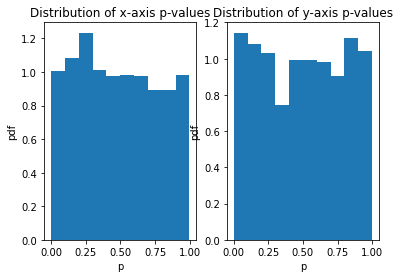

#### Dispersal Histograms:

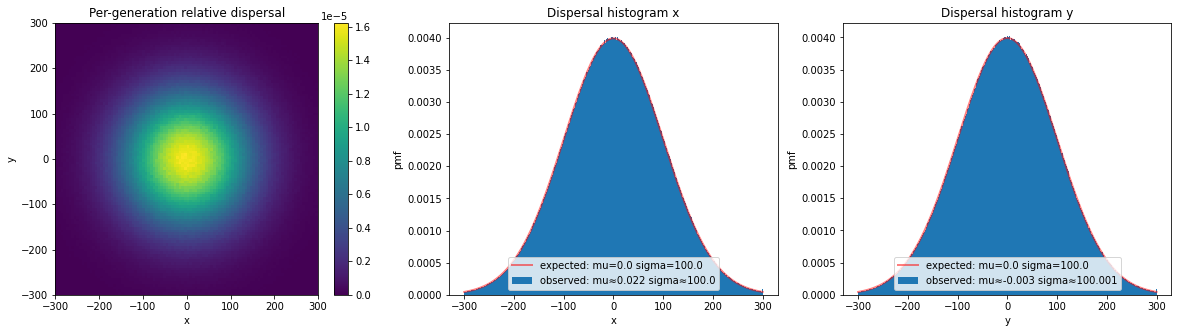

#### Parameters:
* seeds: [ 1594014881136623823  9355619329108370851  9150528403806450642
  8642409204539029931  6641452409968493067 18395446616264941824
  2156039295058977733 13516484569664611736  7701761581897820934
 15166219427818295579 18058882911145088919 15558831261872036655
  5270549706910105260 17670372078838383998 12560960259778938770
 14896960876181157431  6247517319355569437 10393519353223325584
 15840138902717082774   709512459295043048  7018695149069078983
  2730246754046217741 10263821541371710665  7566597238236144512
  8140599326700702034  2781816442704683394 15341642447771043327
 12610068900685700178 15349665804142741606  3482757354513509654
 12821983536703287985 11003212718690507059  5334672946696228162
  3313659343534373157 14564638576284748798 12885462376045682824
  3668490981932367604 18298299430429064119  5667222747597349820
  7411781625840936424  4355875098538959828 18226529712534309924
  4873069822269189502  4625167628968249650 10853800497015446485
  7999472763986801170  6943226678569125050 15226160337475185939
 11596527511222949306  5665353365298249048 13723937432960432054
 12675239329216852042  7221526817277446089  9990785984478461518
 13798497551656066779 18223398424071069871 16802389814549597935
 14022910178415409823  5864988386817864639 10632447770435060052
  1162786248306745051  7769016483684441052 17614489493406021938
 13103132935749754379 17748439740384581547 15655752348375412565
   133939917992359754 10980036124131075699 13146661681595759622
   838779229440383240  8934800905569301868  4535354696382257848
 17449381693785766785  9333919143890720687  3102579369090346018
  6605638790993153752 15083653458766409892 13225856442974969604
  5651864013352058026 12553003782962115275   620704609413482475
 15672072324805565634 15854013004701645067 10968050982285237988
  4565182282906951990  6644797347024612534 17745808268403818341
 15618231558269487261 17508154844999245804 12912859241604679138
 16938737495223889557  7550778909132224552  6736167603492768950
  7771093049752957313  1140317450860787476 11884960429605759006
 13870847819952359293 16300571791611078526  5088752199305699385
   834744104995251263  1409564684879267023 18042059355392642848
  6229083214127693116  6827870972521569921  2810520746898345966
 17847892946962475175  1753689058357730409  6631035099504221153
  3013509170163471379   710005956230253705 17281106363526401539
 15391587064310152928  5691201205814758594  5341924743800063154
  5384425123522979139 14249684405119974040  9992807077094091357
 16962342378605147577  2040165959185684883  5082494948425425673
   504300332345163762 18431929534281671553 10443503027357886437
 11045085213485159316 16235255658476045875  1518558362964730559
  8948534635185721538  8747910499525922696 16101222164516542697
  7285399518746272308  7339203188154995247 18227428623794986388
 11355828724901085932  9128382990560823176 17238297263774708590
  5434315077999115206  6638527890600011460 15738203706450077128
  4481584810580186509  9214643603831410703 10796317978842914422
 16984397264263680347  5892834380434427538  3813756474182504236
  6952487225371524808 17965464043765566166 15867335612528311825
 16523596767553987957  8795188393583405496 14475692908354458286
   313878843418496612 12014119280569339170   839629834530640606
  8022940862853953342 11179569253095045476  6409145627001974473
 10567996585298746180  3250207302158695762 15819029237998359789
  5047590364663639491  7004865290283568590 11659722589581181443
  4753488570367487824  8877079709553582935  3864773807986381457
 12327153575873350295  4997846425440563051  8581559215442125214
  5488175476851185300  1087500421040392223  6383495233517574473
 13047199632921308315   544869603499129846  3234572216114454595
 12037074397001873742  8698619371578444692  7088260334338004062
  4562024426389494419   801736866384629974  7779581429448268317
  7087858168740691995  4399730987141989542 12198595496397540176
  1560515548153498573  6840284162010292785 14045827206571757664
  4723898552617407435 13042840344671092974  6983173859050332343
  4560581450210553010  4545025514219138783  4034514218681204280
  7851292462238827413  5626921951986078284  5042191370341288311
  4995717640151442151  2579988180444041138 15341765670342057300
 15026440389696998970  1396019509584309303  9451607315825060011
 12751481851330965899  8963805095657491541  7987452987602246545
 13198477163102535534 14473045661758034738  9491926200576632405
  5541778282706138722 10639945317574642430  5795158690721393530
 16458783816167442294  2147996603586216872 12461036497534200942
  5813370143796661227 13505296456877128461 16266602963468633144
  1329006471076424191   172818281627616622  7685827930078502299
  5414616294947594666 16799289189617066174  9141825863903854411
 14531504952222379194  6404142168114788148 11346653395662451928
 10523300386221660607 15236747019707851060  8619849600967418442
  7387693497086424346  2789947416438656297  5999397699207152115
 18061665707743172920 10242105403060382261 17663056574438725176
  4903546161466486860  2196321638041756619  6836855230410793848
  6524458223486772907  9731195422003487427  8278308292735295261
  2487790952914405735  3184221798566669457 13890517729072018893
 10704841735562067629 13433999712390978470 11048293714191208502
 15273940162434981674 15332510189349141431 13755301639942642732
  8273438076873500469  9807442477931323182 16277648190149397743
 12455386135789517886   423016250024032205  1295638455575659229
 17170257405770635816 10855238502403724167 13575491426709756206
  9100476359061089653  2372257180030041621  2963604886435126411
  1581267676479661080  4318320583856322630  8557590256614530127
  9577260115541170935 11483109972272129487  3756671831322125044
  9508880541852328442  8989309505168405346  8948797356003971294
 12938215773984576073  4393929090908068154 12189887453136486461
  9105999754343478506 11141589369609430898  5538103156891811193
  6480238197579312218 17125676393637415494  6247998051453187817
 14162123333089700549 10096002492258347661  4693669387302861245
 15747492914074072187  7689284056444993278  8436174621234082716
 13646292184277923445 12948902842461706616  2570039945395790154
  7997668804261871802  3185950418043608727 17799221421853843441
  9928308967942755204 10108777265440646948  1218824682521090612
  4973413401127265970 10379002577590504458 11324087511120489073
  4038000593140471331   345523032491322094  3618404742810503127
 16262836063820539969 11635248135814727110 18202586108567878040
 17978763071023551183  3138849094885739667 18376463948688003262
 12247677730103353578 10656939749574429702 10009109663701850418
  7690574217515998558  5734880619077710493 13836391010934677579
 10835202545616245593  8778544172190096131  3658971516548245973
 13063231767899848025 16252845680633569143 16645599714853375385
  2895020178564187683 13448619320630747177  5197192193616834223
 17317145470984088396 14138330003641023570 12513732974737140813
  5362692566302643889  8927687841195844848  7304975690290365309
  3394529108969227033  8568516766727736008 15518730562647941931
  8086704607953220384 13586359012870901832  3766407346890458983
  4781244079271118394   518763826426458613  6467067124546490057
  5566302148233768104 13307326880847350164  3763182841110800027
 11838539832230572956 17488391305370609888  4150054192196871205
  1381601479556016207 18422735273145185576 13259018307403644368
   350005493584556671  3442248982464318309  7942078880645986770
 17060387499017255264 14664187133415540986  1147241941590867180
 10695030517179047706  9102684295481850650 15561998190575792985
  3433853982715804021  9344474054308753820  3556791628914006136
 17957734279939612870  8946349425027533668  7713540663975647447
  8551766640241159976  3792820344384093769 16949021889060572320
 17029765688654068126 15128820460275812168  3703997979357604160
  6938835476446979811  5255922567769634786  2562306335573381062
  1025608102437941729  4837858726695715413 15022150456289898881
 12652061160508941276  7773406113263321634  8210860366403153371
 11569329821873759792 11578000486913486711 11308372832415831474
 14515212876127184839  7049268055753192031   835891667297894255
 10842399016977632100  5040206002458449414  9377484975103117992
  5536688487635599389  2181659467499906773 15736338763223045471
 15112670800688496746 15192420531901310927 14402399417119956719
 17026133996168832092 16147585647099090949  8454831911978216766
  9943585272665156523 12994816217678389338 11135014642859498761
  3307792450627137244 17995901356196219293 12952673240924684570
  9115940755460069457 10495380572168531483  7906677082762858761
  3969314941884411909  9677379958061393347  9400450882358083785
 11122714399216128699  3183955411205518617  4689684482645790353
 12663753836672342527  4955815405885498450 10519341175881941147
  6071897396541309191  1895894502334181124 11503467007584261654
  3822018466994083320  8725945397918881567 10265564223727610193
 14227609604985677892  9214414472706221322  2856800384158750260
  5413973428063694189 17577485634639462244  8549017460243161780
  9565502991324953574  1599411305971351542 11590848742486891404
  8881059028231234728 18284898128661525591  1741934414678986271
 11058658882635224668 15841147605725663113  7505120295977254896
 12834730206143782583 10116975290000032757  4536542201112883511
  6358312223132842657  6768578197467515035 10165611598939645661
 10091528881768968877 16614169345974168654 14072474506425130164
  2181029279419276941 15608354559518365773  9635570339622294547
  2991645141865590647   495528418895054629  8269675861730540789
  1962379471171007520 16597050003415944723  1930008379491586643
 16517130824910990791  6271474058623911664 11088713218230044733
  9872036868631067687 13317483523846470508 10228447439700186653
 12816284869143925395 13028643785643937071   272000973724603955
  2609347874758030030 12492636428963399212 11927494600541790401
  7102057776787431481 11931316049448224144  4903037035136307405
  4072900011318074953  8938880644593078303 15893221902743626648
 10475416242149578414  9450641323371849061 12933366118434514349
  8920950928078886298 15547244717605012769 16915711441138271865
 11979941572459236512  8487166195390805555 14877414371925382403
  7904069496871927613   659116464976456456 17938060833130290378
  6537225480395752684 16825872467372131541 17514607720751992729
 12300568153170982741 14824799805572189771  3852884928978562604
 17875877713403938918 11127882481238489602  3417603108646723745
  6989018668085269466 11644385096929770044 15895938431028723695
 15380084911120196622  3619222935246145826  2945702871683213939
 12502154848609907201 10175276070866862511  8922883509438774045
  9646114573812629799  9349786873238096411  1265526373770961783
  3340489842199646317 10936845491085952432  4341656914099956348
  1748761797133458611  3609899088284138327   270492662302259047
 13293335151900921342   317261729664170481 18330840571468025154
  2229841389654548211  1089329371915784716 13019580429672198903
 15718686905390926895  3478130006201146639  1298762058999914770
  1369794175127036510  2719450359087625923 14674422950658769050
 18135938682539957141 16884730495806647633  8083031902780953827
  2897014973955580022  7842671642729351575 11933826495145004154
 15494012700394793764 12315740443534795261 14230293695305048099
  2462924810778490563  4284959044802494660 13197248647836065902
 11733303159694270939 13495014528729802392  4841299412750136808
 16068956829170703093  5498612688467103202  5121473429285768214
  1894596195926040729  9762097263356403654 11931864274013558338
  4741830302632989442 16975671941169839870  8326917954649893743
  2264777911412002194 16549770347887211687 10499617186852602571
 10012407799007967887 16649351883051598341 12073348463684516060
 17454361806375592900 11612234047835929922  2697023324040244505
 17457569679158442694 12491933225861961009  3073505038592933588
 11920150795672942880  3047926123672700836  7108586659616251211
 15912690228019601089  8439415615375361514  7722661268798721017
  7445260402523253834  3927144271838440686   293306798284518024
 11634043392376222484   400036961514378119  2258748216457720354
  4350391916361615475  8260743576847607446 16428883731269344892
 10347619070731985529  2512222648219986720 11051014489764408740
 15306223214209952034  4475867152072491364  6662467119033232083
 17090039523320624144  2607829253909103340  7086213244822491013
 15978481614866774317 18106265321577080383 11630813220495217792
    35912283806021985  9658058206184203369  2580545651199475066
 10651957505568755366  3706544564853414775 14093338466929000393
 13853341139947037945 16066841777952498072  7345484779830539725
  9443980376483287685 12416011195179670292  4918091771956735472
  2495204567610484731 12985302343667392912  1352652409478013440
 12949955481954310899 14329485228769288797  2465727104642803499
   551217355248068627    82006005650620938  6146769499235079808
 10157345345957577917 17136750499376297541  8309108321900971728
  7579971670977329023 17982400913004526188  8714334891697937214
   107880531529239849 15138065462213967667  3287471709545090987
 17775280965723458400   611196815450066816  3746203175183373520
  3987511657661056239  6417146045985850290  8850410404253649157
 13275163316131376614  4119912807592507802  5537261696637253759
 16596834897062866748  6374691147982336645  8301385653869400807
   683029987869020541 15711356321052873271 17627851310376262031
  5475522719367794274 16634103121936910480  7541615456876715560
  7399576127897478195  8743517751959486615 15196365311666126512
  9832855919872085903  7473746597417880564 16620983150040817035
 14120764191070352536 13839260244268020636  6109292280485279838
  8331643567329943602  1573270600613234462  3864936628794498054
 10168662812072811024  4531874739011142319 12098913555405146593
  5040907854678384916 12125800840449057780 12713630828490018678
 12549176374295788246  6418721949208756592  3058275294215827524
 13765677838462870368  1318594070397815640 14319128309788983054
   823860059066888690 16544615823172008132  2600561374553032933
 17583567568360519607 12272940660911543049  9252438320135920458
  7571394930144928951  3034335321299241348 15473806923096477140
 13669613868160485585 10534610710441098692  4718182947751205061
   603808426920233361 17603713604145694113 10576022635794502293
  8330674130160225826 17216382372805600662 11310439601704288418
  5616194274627408308  1446429964003394321 16227926338343745571
   989223513445644009 10099727668124220721 15581955057022894710
 17270545990220899612  5726602901932286067 17660052296275107581
 10167441047518592564 14360487747948086632 10905475560302514060
 14830298262839222275  9836624444999299855 10084209118104074856
  1810557026271633666 11281988265661253290  8475882751719620182
  3000893475613410370  7658865031001459429  6639336441804314183
 11540416485751073996  5722762453982918667 10698583327712618982
 16332173387975550157 12290954127605320977 10409248860553357840
  8143613592958521603 13963282471099799635 11667785062999340017
  2332065868281327400 16340872310926158073   489525937663601686
 13211370686375220975 18271189891295516240  2745039285980214279
  8008650287484887645 13981233089538795101  6401338795848386605
 18259649062343118460  6209354270987486473 12451297066893692479
   480885995251184826 15820524060386715339   773827397806815614
  5597301806041768264  8902542157770009123  7446808183898359117
 13330281391354738984  6211243804059030711 16925991281262664475
  9737883535287450146  8436922074891197831  5131601425900186041
 12889596277343751595 17528255401115506521 13568000060093970396
 10538474226947156619   832930859249973300 13435837792127491363
  6363088421606655422  6387823522503538537  9932763759360554146
  4202680227515276963  6865048475743508784  6008854707956843115
  2978526510497696456  1202002783449632158 17441773148648742826
   881658944227427682 16137213618043991799 16128912827151031428
 11845549110769313544  3482431492752147030 16998014725368552697
 15004406462919936518 10479418845773776797 18395670837448905741
  8085435767390719450  6822190916780124106  5980010797529941497
  4052792012249961775  7134385642480509134 11961739302898030522
 18311671695336926984 18196280593695495549  3681626244921928998
 12297592796347235234  4176912621389310441 11292936820140243823
  1926010235584438712  1617354091819903565 15804015211912734027
  4898333153460082216 17711991020072084093  3932426199466701317
  4724499735256531126 12309914742571695002 15269695187628511625
 10091266718235307684 17662700587853363423  2405206376611092321
  8511712606222600771 11547230820418121536  7261202276871383137
  3355237852430044260    91402635033294339  4430503481947799941
  7749468643581736713 10796587346011913217  8486464604830374356
 14744536953164656296 16175533601644615204  7671521384202501743
  8968913287464263971  5562571174024741991 15830340264846937920
  9561086366867700906  2178589164916910588    17784236338337460
  6172680751779117460  4713121343960308835  6987269848293138952
  1107076971242572331 12607442494421842035  8421045793659628691
 11863382501682294463  8648956445409838009 14675710873738137972
  8923305159547496019  4552134589553986730  2738507641230716001
 15114654326186120117   253558879882202455 17702019593355246319
  9065600252079871217  8922325164053326502  1793108705451977724
 16490364229062357695 11208417728854377720 13795748679871160914
  3462017012733371963 11006599061860711268  2092560972524554258
  4211333319667551959 13540867043625276834 16129652505122380310
  9012716244395963470 15777041479154398778  5810226597623835024
 13604797068834077860  5147093472542768077 10728397123549557925
  6546567963486032975  5000718112479094676 15919067756505823604
  2813040024170377826  9767908472172620887 13033963640118791090
  4337171051706939829  8879160754148206641  2347618763489076964
 15082699294138448550  5589139615966783083 12704972247588035266
 18093323420453453171 11969152247652313928 11159657885406830810
 10111830041612454792  7413717052211597460  6078952384493830629
  5847102392048425461  8657012564790760696   581738386624753333
 16677508576640722887 11168432786423718473 15257450346535988727
 15145385222188874399 17511241508747694579 16408268841232858183
  8505096459674970174  9245535507450928105   704975730680966313
 13113674391467540179 17737403665197256426  8990846528126779143
 17352145944446833151  4427094995343040242  5555553158219743419
  5191324979129324624 10226495845113844392 11240737235375204138
  6951707578758953696 18271726829724767785 13520870257133299045
 18220031412976716894 12552439911782769892   445803490766704755
  1512827537410638942  9217219014315755368  3832180277178277848
   429281557981875582 15446094845857166838   981235968485462761
  1723409414984725190  7645620912654887149  5700191597421142974
 12139835843143099415 11267487749956606029   753336537526089173
 17376068904003594876 17056615309917225433  8706583884296505295
  9706051190774820373  2409503968982904928 16887605469216689203
 11792571658664492197 11140518506750338207 17303736498438727008
 10327664525575824105 11438685575141816814 18389033706192465815
  6773630987315727113 11331070654819057664  8306531663687558653
 17268572911808076512 13070252689039774916 16386161993385081088
 14027410793046695468 17669499731867693385  7534810943271916341
 13050371037071004371 11758447633581268792  9955657658897594971
 10314123035154765611 16113810386189094567  9161723391065537230
  5926592867370712141 15024196196162878955  2722963657826748784
 14686382348440031075  1840160259364632864   439933767689516855
 16385255719644190531 18049590189702662793 12085268341938216433
  9788529515927575123  1726186888360251428 13808777573143214526
  5114743229362406525  3459942878827167728 14320548880165140438
 12314414977348871718  2360467519385612538  6341840472636275383
 11136706575475896019 14852895155490699113  5899966053135022891
 10927207996403062847 11122975118235161471  9513688690727693702
 16316473052645407475  9735198939322914852  8355442753749478474
  5052132709043825643 12614088885640319983  9728249573344777072
   410170474170248295 13524345665469819898  5895762330797116061
 12138045969571660714  5776487045833863169  5736949549613331129
  4335338668173079792  4909792360877141796  3819759633360145555
 18346684660724498296   226948740352301110  4154536354249556404
 14171002745183295421 13503628194738825813  5780514620040819849
  9295312182942801255     1033251108042596  2295294815259124657
  4335206493020146258    37570265814338621  8981148163095493898
  3023327293304301730  7667949965887823987 12788307822882273334
  6035742004358803098  9330864560744308190  3040025923232428902
  8616227074868002166  6168391609019951660 14000468561783053140
 18078482814421157263  2076071487761159345   527920345514831067
 12068113500581294035  6729387553815823501 15131123313680598833
 10862148755975821821  9267162283125776368 11066874970375991454
  3246074334657253891  4638861119706627581  1169952272877742835
  5525095003823672643 17660641534214081682 13936489009464780741
  4990537529659096958 18390492689825760401 13609304288765208648
  3642010930830528214  6408260881880078557  6793726925954608981
 10179860821461137199  3881259322914261634  9635859987097803626
  5664512581785510486 17052012399730490729 15420571893665743142
 12443144587604100832 11537368734648896663  6617038841922195406
 17826046828591525501]

#### Configuration:
```rust
(speciation:0.01,seed:17826046828591525501,sample:0.1,algorithm:Gillespie(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:green'>SkippingGillespie</span>

#### Fisher’s combined Chi-squared test:

* x-axis p-value: 0.3329482962201905
* x-axis statistic: 2026.7610696215054

* y-axis p-value: 0.8112480652639313
* y-axis statistic: 1944.0477042912073

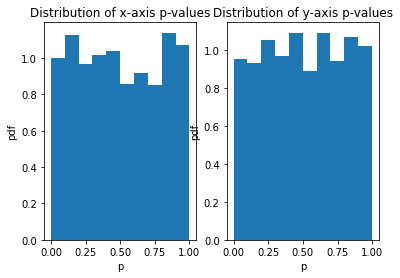

#### Dispersal Histograms:

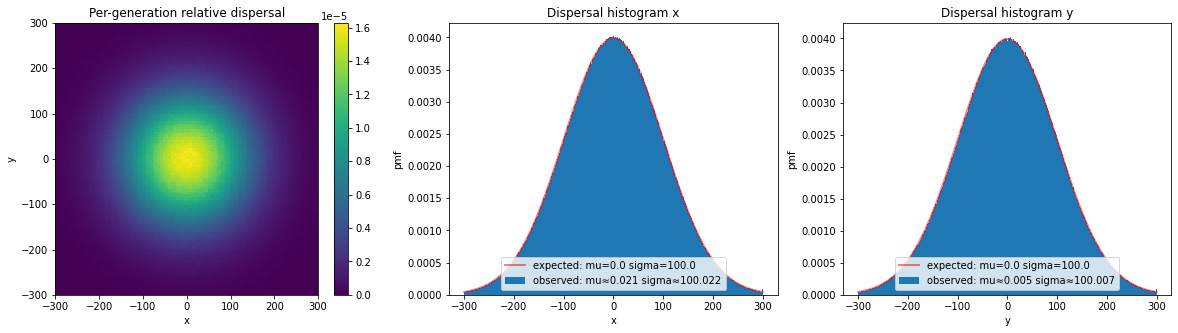

#### Parameters:
* seeds: [15813666011867791968  2234201018660954097 15728425877176732150
  2481367291422624111  3984300603224464013 15549824240996875310
  5574184632543809882 14230200983578435545 10520078261592021647
  9542962508865401205 14168389029096573915  9187606378123248205
  1157379302085799674 16374935851005224338  9301593778476040281
   365467312570662264  7602016713419660115 10046110139036339701
 11680427009048041073  4288392411846220169 13700498977826009930
  7216631165235801364  4736839197783339559  5763778471554321759
    27614932442328146 13057366062275840298 16454346747333030212
 12493080096658743797 15468244769595831527 13265140524416616939
  4972530398157944457 14665308774145497760 10630056477839465201
 11649457868032668721 12897655952268534842 16734730428413706115
 15582790283666048870  8449331868151075048  2114321716328658557
  9250944260025045629 10522747619905088086  5951215218718624638
 10087198417194797758 18110592758762605639  8986170918656750711
  3827619232336996279 18318935326167070155  2325302485414332474
  1258794292444201771  9782313235734988908 15265023628909778638
 11329823894523851375 10372887215987723364 13374054643295570327
  6699161407228997444  5408673299211721557 13661102927935565698
  3626065477450843952  1781428084193020945  5417960767135833019
  4460258007337677807  9465318046591469987 16772794727258941619
  8202392782396219991 17163377242366194233 11389035906867141051
  8680583442176129829 11037965257310611499 14304132726090423075
 17502139802227445082  1123435184200497962  8613014600870089751
 15024699840629265898 12266558001005105121  2576591658433489021
  5869433664867770950  5716668079053884130  3782765903127509031
 17008910238596185803 13495220882615437843  9365504879292289870
 17569858945270211033 17200932601218664742  2350511853149372420
 10497512515538268539  4887800275380372442  3026777657716887088
  8612239328163642769  7671018150024191284 12660762713217378774
  6927139867334645222 12724948220476483434  5449149458689269314
  4338114430724862464  4271671891497008802 14096431403356094860
  4469304322098667531  7144589065652139645 10970722612241350773
  5608458396521119204 15635596743293265711  9828037367299785857
   634148569081488351 10568005198766049820 14529868825041173837
  9953815437723935371 11503060076145430354   418433231471376078
  4860918468668648760  9409865269226734020   828658753939789269
 15039331929480186518  2613217447363674330  5563784838875128031
  3630708770444655530  6108802704420077274   484697906767405296
 15263542124432668076  6283350810892526441  9494473855591765452
  9439261723110132273 16265906098371408061  9760234045801448338
 12054897844746040009  6628047340046047824 13749706739844180611
  2146628595981178253  4491780411155448213  4785212678297345897
  3430475178885121457  4028195659141413423 18266447781083737886
 11200962728407292984  6231205104014159056  9824677976043104148
  7867875800668261528 13611264016923680724  8355863643114918875
 14045406490354044693 14978441153549421352  3776636501428740506
 13059962431165005906  3436110914739553918   411805179124120801
 11049677474802001919  1004640306477104035  3946494137455689679
 14473146121313709067 11886732220749249437   168781915472255777
  7032969799662893499  9111272062089002796  1537929394377905695
  5628555180374593777  5421537678890539397 12375666513771123513
  6725867555393363680 17826346464105381510 15388543769335452282
  5100704311244194511 16242978791685608823   257552819379802983
  8262951638414891893   642620016549438081  5092626834501432833
 13894589876923800849  3048130948633440181  9802164437393897564
  7367884551744672630 11510997755193107278 18314836427397300805
  3869356375791834147   882686023129880239  7503545086295537879
 17362389022921852951 12039723725989859393  2085025919812210855
  4349631405031549895  4843205017619255145 14341868546742225227
 16664329397738969421   577708442989907976 17961325112872727246
 15010551631585843601 10784615835926995970  8572927987264939017
  1765692072125792689 13684790319618762051 11451796752844230158
  9838763859458362065  1619085474373473837   933054144815279865
 10903987789061344767  5569867479793860161 13510292576032455061
 16093101722164961453  8078609867152128926  4149288647818685110
  5988709670997577635  3909954222501985891  6526317795251151023
  2688412178780435674  1392545690713129821  1950447392335132079
 14338554542885170471 17455687181191734159  5409808693127959171
 10328748637539565810 17106559372318237690  1418002985001632544
 17538702889894247250   612360670388174290 15296209010276907451
 16202527768905298001   726463624006131897  9140499791079643401
 11350537965367033786  4328420975509875644 13179265942917096510
  1991054982510474486 13817750877979857889 11978050662373658027
   885042354617017922  7701723843465555799 16500891855908849925
 17986154221944081367  5074961520445683817  4359953981528766178
  5670534537148008814 11675238177689103906  3652496208885752471
 14934149887438222388 16931030888776038537 14814615483954647148
 10202582948279767315  1781869061525814872 17487304167931293915
 15568136046507586091  3249131938899404364 14070924328400476279
 14988207010957807416 12721705963886608716   909243042225055031
  1577881154569917421 11847736735351363888 11715320765853977933
  7914549791320619105 17926940683338375747  9549420388763002611
 13580155715166001367  3703843730085207040  3216983684702503467
 10326914063828777665 10927469332960454660 10930103821018222653
  5367096670690574410  5386176326830471832  7043277764678277079
  8360772734137709324 15015503789087724240  9758177236708299177
  5931502798664813631  7356187238340017247 15603775774310945792
  6032230867404547135  4303282324408923032   822058400300536806
  1320214450837846827  8085677915582679360 13011300614032516377
  3170974399169818286  3380134298483140420  9881078406118836996
  8990744246534523780 17006705885035895825  4907456370734290527
 12036046934098343927 15836461630987588135  2547268083453663525
  8678392790555000073 17822192653231414905   288149440003666251
 18071749217805534043 15248013925120425521  3094355745563156872
 17502688159109772366 12394221299728687162 13542167464111137039
  4381280017725322271  3823728201880193292  9362082700176918867
   182851459896802511  7281580452885930198  2320716321160573828
  1340996803088192404 11267609720091029878  1451783360918115028
  2357329874193093113 17693208703759541107 10467884025040612203
   541199462375707337   778559677940642585 10949709436583385716
  7121846012668176771  1814130796534736534  4200745553468957052
 17533903357789677399 10588048777368896546 10949971184226261861
  1308859725931782974 13361971673205351767 17149441547509229827
  6539213523384616345   507584607931553941 12493913051469719323
  6200217250227590832 17707496892786743925 14108164928523321247
  4415049028297906483  5433778711768707864 12585556799729200836
  5103945285772707161  9164059728684662885   677965247257969822
  2175010277479838083  4879557371261825114  2976648243664883340
 16721956372859618428  3758972060597263843  8467596125412959766
 10597140836601378249  6844636708122601450 16401643194937509642
 10025666236299137837  7068564852511811168  1868338868552003413
 16341780467644861473 17843829994182747637 14075526343319480619
  6907072084906771711  3819795197635429968 18278345444814907472
 10897582030941066969  4419657566366244770 10979988713891327071
  3195706119812853342  9224105392552140938  1987835931149600749
 15086104097334296372  6671370881152378993  9207977439554816436
  1708497329657718307    21810028372725397  4425372421327889898
   939697162147159224  7904846388468422028 10730257689175911052
  3375900294985861283 12539164379485463798  2103899608900297586
  5389688048632665068  5096058625944864619 13118107173428538516
  7449009720074915964 17970492211951020085  6437141154903917770
  3928103699842126043  6124448720453881249  9568753141176683461
 11157717489592598018 10815714081134773254  3955134046584745305
  4764620976677463254 11534341998836834798  6324137720522435778
  9778643064434363826 17984441695800091095 17139299805005288803
  3247058897759188394  5266903436059924950  5141905569988867402
  6800587308653012472  2510607562878583628 16971711531110003533
  9502829199975640633 11083562473705745010 14491610152094710068
 12754746715905667469 14141211827518531116  7983155232402014648
 17046139196597431131  6797155917554302531  4010843119094465528
  1655238159238887175 13269507046606642093 10355151505910752687
   114408789376386098 12303526429309465251 18307793198818905050
  4570254962322529654 11783134106133841471 14771987039268505232
  4175129251663014471  2829521274092601726 13890664612518568537
 14932533869955295814  8218773104140084462  1147349767603046033
 16559664439962589622 16376990583955000800   323015972012735142
  8835690077428024831  1691676455626653967 11524134303011236651
 17096137527238176263 16000043762614670259   178088056454680722
  3275276360474481770  3106730881872161849 10488543404158995079
 11793730057544138009 15104546596085029429  1921170425656829667
  2199178912830698286 17482519157922730550  2194649280768994021
  7411779760413999162  7823153755199767765  8325682469728034337
  2214381973638261151 13996065533468362505  4292766881293270837
 11422986138948211757 15728194375743355514 17958754463612067960
 14661662057501551749  8122582722793772420  2315304784210358052
 16911757594156521479   519706912131289897 13392815713858509963
  3747245971342209642  4504090464574081505 16190779510720478136
   190409630811317564 12197253292817073094  9200057767584298090
  6422280785216227890  1512914893801982798  5541008231245413115
  4372686999434344307 17546307454357298866  1452465358902705994
   116972031780122733  3585741446715234156 16418638083925239097
  8113502724696327776  3709742334330234489  2564969218159383323
  2009988842309640391 18386886987780401345   509142077019016715
  6089473169231922906   872220919964122938 17604459921984214579
  7047312123378489619 11102774595596388353 10707367298614910310
  4413205721239490937    50487405075026381  7333154968338763050
  1121949741166767659  9734642248099503258  7567575338981080950
  5910214311823600704 11470252458195829468 16622041649131367466
  2186166179729994917  2176515421119297578  3709437389230785404
  9286080976685694378  4595701602900061645  1482625185688287808
 12339060122497423662  4236054595584503351  5521216202853600063
  3667033799485524570   295236523014572334 17894367989975396757
  6346909399000905409 14016613544184273714 11929301220799292171
  1237543122312954119 11780042136616774057 17583869705739621299
  4494221440232499380  3770881285889938155  1117718788077266540
  8955407829777504924  4183190152667293153  4491915137097836265
 11413928655879833016 18407597871100504098 11610408442123207093
 16715813291729679190  5229867589917198730  1173616740959724477
  4721598166707434456 14383640920743518033  1391584887034731524
  2841512519512672053  6614276091118418577  6644560778286276225
  2524183882994794461 10726854207578218775 14468472425635539679
  1623803010536528203  7661989833229641339 12785711975936945099
  4281775861626474035 17395773645357389950 14634348225691305669
 15655953519959726615 15733246593813381559 11483793906462839502
  5665811956894307533 13849335603634529684  2321876959480874234
  4035032698775642128  3638718688953026119  9294843195806861540
 12082202839148976583  6329392597020542804 12549072369627648340
  9832808889953838818  8363428944376223877 10022845242545252184
  2107852769389327088 13877085261371523475  5844949535721592754
 14084910573411653623   565913549853265328  6733360047387780389
 14279231094528492766  3703858160186405339 10219612720217903540
  8454905509233304529  8407059676822947343  2606617464228908591
   232752018144103133 13701149203177721364 16446657969463630120
  6396060533761895711  9745454193110335836  6134185441943924212
  1288327081325203216 16452821454318896867  7764606716859887449
 13638776096366897789 11232103496187051855  1595441171305172195
 18376386770033536595 14105156750429136481 16437687073880955933
  8913269763374509766  6652294344937569127  8380438933359937631
  6224850570120080804  6824321985188362804 13193276533179213051
  4567401651924370912 11357013670771040307 12212781959144366816
 16597164061206688099 13401161878913788193  7679443622111639652
  1086585244694217857  9088674050004592364  1882970623611093962
  1216398054761599574 15932141773277767306 13756557683845213051
  1956246592482946465 16230574379303837004   891946446331886175
  7574388310598289076  3222413227795216318 10654694674959468299
 14542393401469830067   537397740484525147 12347800490141205102
   350157226991603874  4806370222247279666  8225198057317912618
  8919055695747453068 11098952914272522912 11623161132922636017
 14808539834190287432 17199910860659077890 10217763662012865494
  8482121782296186610 11376767236275380432  5237513211800244963
  8851271056203786765  1695221309005393857 11400143080059516706
 13671577885132691653 17344056801287105216  8689425179677146155
  5974324032045035814 18283333626272340268 15441760462765759712
 13199346451615053203 15705741551661909389  9309414893467283140
  9205585914525807553  3263495682167264305  5459436755415599169
  5128943902502618915  3743624343972413837 12265978018146448329
  4281916288784228347 16582071718863890198 11476459411898580622
 16760185867289156550  6474092260775451406 13345788748655037183
    77443691022724341   810661984705768882    29701385177504787
  5092400215077069019 11390068037306911890 10801969854841783352
   753004620198997550 14295119464753753713 14589154945790836229
  9207858110909444917  4015507611859530454  6501979582840302857
  1516573138006505332 15408596579149393987 12553074649592726795
 12882903444424063581  6133981969114759307  9909762056549465673
  8789102799666927928 13554152915450375912  2970431713821471619
  2353772084109332966 18292720663166609479  3630410089560522994
  8774797629132688239 14400432479237109568 14829485042554400740
  1900049308972440172  2687083117651128885  8782820836766880571
 13062336484767838399 15846516769720863697 17150641824218365108
 17013266363976135814 10749509437456098934  8813813350571819634
 12440350497244120442  3266712817132897107  9841920134211345570
  5625471439784385508 10950887807472978067 15837125942361310423
 17974911048252275192  4677427376597642249  2277829614228690617
  7067519559580348323  9064189039263627053  3878419241228732018
  9071198464582945031 10095017678384094813 11278355550773699270
 10004132955969977975  2009883227395111129  6527626292723190966
  4483449945323460171 15425020310404816975  9764460540539934656
 12197556771818101153 10119620953033623025 18446367717123107324
  4838914814938803384  1276390719865672701 14121735422895786806
  5908846820030722853  9314521786520726159  6748863947821042159
  3920345922128185719  2005123254063352031  5364589214844886997
 15547353583031000515  1599184577413033286 15933275301750608118
 10981420874483060379  7162881959335170627 14682960640743697241
  4756513248959786357  4801209807409701380 11379837452076719049
  3054696899585960214 15977958384576988974 11461418271385782323
  7548455633306187085  3741310628155730804 15353341994098852040
 14471659658036206387 11961103776225909480  6777212198880386962
  8523181366702496563  9424010456135558393  9609036777794896394
  7042420090421715524 11892191535537527400  8201518201694376449
 14154576046582075108  4573243545784421527   591774273037781218
 13218157927850319696  9500771911076139354 11958502731718190831
 14855554035447160793  1288210904413501506 16942598165966966428
 12670492770425732875 14598425315350914108 10581828171018000726
  1032057720216861317  2953015008588149285 14959647074935057418
  5092108978558756393  5472459438077174846  6902724959013018232
 15005051793822948746 13327120580378265751 15857495684308980548
  3563321409712381237 11822534544137177203  6348551354348184281
   804741611957644250  5957000374823532996  5454852822231346430
  9013522729530195766 15871131360941920679 13640874687082518898
  9741335922072394306  5945616030784803339 12064438638284236879
  9524955159132567365 15322094351122709451  9741594462572791401
   403544980838397269 18312966485256438321 11216289033523920200
  3612625868939931443  1640648193052896694  4526355318908190065
  5253028277991370413 17071748891132234505 10284152029104624432
  4631815656722845859 13757676134294053987  4969392976151951650
   383893071186786404  8947051945543064761  4114185213307852790
 12511283144361578235 13806813235859648795 10094295432852102077
  5704736895084327722  6418676181956700711 10401313380178458634
  5034106880872094362 18101949821609093013  7167300297180331441
  6698263420306906243  1088763572621381821  1870715734508808671
  8014149760648588026   241824693158958277  2388715264840067142
   248501143833401472  5707827398424657429 15228111988159969869
 16204036527244383159 17345251457659567972  6070677583098685012
 16467559670251341693 11234570864909464481 11262590808072422105
 16259151680130351022  3579153988817347539 16433124586982931550
  7890723131324357206 12492196822205557893 12817248987197208443
 10968973210488690488 13589841329385457622 15685223744229983406
 16937410456096924317 10938470442236858977  8888024383792670015
  1927271417124125972 10901401709494247868  1949574867483933163
 17993717522589884781  2637391748536900155  2040397251335471420
 11704475386891312997 16802203101170457992  2220881468219433524
  2428890421499619264  6595541136284615192 17532570590370831335
 11122741958113016795  3879101108364658529 11079196343048773239
  9132282161839480953 13365224551750932620  5697826572080328346
  7316571673461668785  2137429585110512630 11806195213159057350
  9087571897903749289  9239607298748356756  8363132424490094752
  1502655857661853194 10845472490957985837  4468182871179609467
  4933095415854429418 18066738479326374245 15318670951666008865
  5982450495300074893  4916301603358795975 17718693162744780127
  5215193823431193405 13777415202578775226 10637309631921796827
 13392374542645690611 13045875178335705035 12218716262752029432
  6226734874360161060  8376022692940569859 11428552795524286358
  8800345338391752983 15358527422310453940  8071355111625596513
 15646705032303941515 14764168894299819815 17509751413000420080
  1236887802087997534 12356666294672626913  6437468525895669899
   780535368924012531 12316713206754476043  5590580512742575578
 11591259985913975892  9280364116119806103 10662270289377230536
  4928220838658975238 13554732327027725457  7263609602542977352
  5963000718602804501 10982511437663275848  2903734180378742895
 12324780397120606410  1785729093679608910  1093937780461348917
  9312806687248262055 15808174401613596304 16378631920808294997
  6834119451952307941 15233812106050835340 18041574519288979682
  3017706654110061148 14569875833128210375  9256481632458463021
  5047160852370519612  6284515809847616171 17022651746400401515
 16758151516967152816  9928168455675971638 13144428111132181757
  5007395392703723850 10357009751294437398  5623367233242471446
  5076938292567099867 15066313772521773290  6549884443451605761
  7915377052553241220   985949600399614508 16155705972999709071
  5516540139170828090 12320563277749410369  6054173786022159836
  4336121863171565526  9403710985838962180 11920911570253784539
 11624200545651945289 18429489335379604125  5684409067503519631
  5156957684438691165 16606015223992766750 10885285056103061868
 11630096750020826582 14155394179554760782  1827782741364534521
  9953064749665696488 18029537803654577975 17297132751482760825
  6073384363040770507  9804861514135018094  4104742919203355631
  6771678724405213601  3292131149393571488 10133392333084902549
 17689500140183545675  5519165981857958116  7724818736506461563
   586683953186090843 10155792635346661651 14825846270314670749
 14126882664470152707  8689956666472321696 12850843268258139889
 10039135220524193977 13119355888140892595  3453756078645376172
 13764371391600225807 15062977574759463689  8213339101503321573
  5565408149472247006  2294433924688593096  7370271947976796222
  1782272624995418234  5362237016134079851 16311576998681008601
 12435190124647557102  4429470467860051146  8527289609157908047
  4994612422693087946 17518363647461235376  4481529863613710940
 18013178457936589894  6201914336528858051  2540930131291788637
  4527748188688380611 15402459990285439426    33076681404294605
  6046994178870248215 16875339325752679222 13526411501009884115
  3625766804298283229  9752276779706912099  9273704993611560015
 13069102262496281066 12990091115335757729 12219060891869480922
 14718416775717785621 12392549160158953520 10672571716217640249
  5531542528234751951 14124368300518199840  7424588132619194490
 15866038493080534662  6975387760389050904  4807085777663472556
 11694828477679214405  2135933881864752297   663531649450487016
  8438474056929734969  6715983942481676820 14448876865456622634
  2581724990207704688 10159999966063228131 16727508611535416009
 15717574816753719946  6497794292818634568 14864766739999270545
 17327327669181541767 12471782296271326556 16783600696265774575
 17407166330402398068  9576810917209018988  8443218068957554154
  3397682350801020766  9674345701517977596 15617400917805502943
  3898281049630917952 13398478031182586068 18171388047606957471
  9158365495486246500  2415462721030707382  8618354258224560201
 15863536322440444916]

#### Configuration:
```rust
(speciation:0.01,seed:15863536322440444916,sample:0.1,algorithm:SkippingGillespie(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

## <span style='color:red'><u>Independent</u></span>

#### Fisher’s combined Chi-squared test:

* x-axis p-value: 0.20784193643303425
* x-axis statistic: 2051.243535945485

* y-axis p-value: 0.022721624874834125
* y-axis statistic: 2128.5152441934933

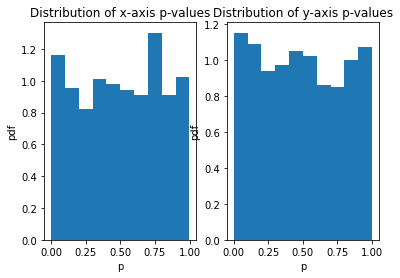

#### Dispersal Histograms:

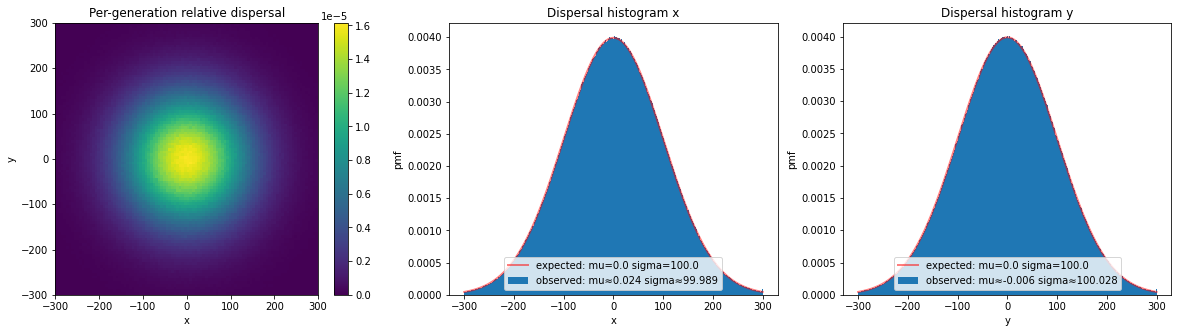

#### Parameters:
* seeds: [18179743822777489674  5193466991723541090 10069734001355281719
  6875721228112088900 15427405919254160446  4288740665037073117
  6334167711388460797  1247478770074677225 15243701071213653717
  3865279391256058995  4681854043487319486 11386067088919550904
 13712868547484942050 10376477671105629139  6526360164215285199
 18104274030690966602  1434137432436797786 10477556659659621266
  6756054089165923046 17048891343441561842 18137551453056561183
 12678763077124248255  2125703916858627079  5015713661079889989
 10358148963807548080 16501402211036678113  4450912964280769805
  3140796215502718600  5699493955281244195 17176924940473924786
  9935949313722717923 13410717958753909108  2620326261776459460
  6887685649819195012 11642235738449168828 15271297036755708450
  9408880636336401485 16426570833148146437  5414407835235770227
 15406386605750262029 10117309344684910833  2487466615650518421
 14426151853880806420 15303554325523821945 15221104918473194642
  6256517036679453222  1418501656723864387 18137878979874092228
  5032630629927950567  8418316566920127103  5597810285425939759
  4188936331923074878 11556548450819578390   883534622503653808
 10301405956030961659 10386036649869644670 15499100823583215213
   983842722167481061  1427897884012473132 11385697024296438927
  5276771526900535445  1594774580999794726 17084722929817171555
 11060265011742019302  4589112337090070467  2997872542409621691
 13877965942949452923  2744671139184622518 10209633404732202242
  9424851859787946284 11821018320446897294  8380383246668803708
  9332978497009144906 12278788195471988647  1668448953079193553
  3223115202424187482 14502173440270874232 14430144426796035480
   829176605466658948  6872353322745958360  4302856267343963242
 12854682977934807214  7511763649128957912 17571272105697639742
  1633713384568303177  8968006770054130773 17408087266159431272
 14817107701228912682 12767469277368152845  3848387976581353857
  8582968330857781997  1859551300223596230   782691917354032187
  7169082923639829115 18389563120437143461  9346505081651817079
 16947982294182855817  6496164377918261678  5906569182234277310
 12426572769651671884  3736566852707692635  2054192309239095464
  6549299872383550946  9201301451804626212   238816600543954475
 11860042217053095349 17274940694356403754  9097759794814144043
  6387892083332453009 12951042581040589787 14980173227366585263
  2288844256730893047 10531119875509707978  2117493827136296018
 11564815968331947952 14001920328183948312  4835474803086228746
 16701553547596333309  4403547957189589423 13889717060546479759
  1464927387646089471 13592999819014256370 16903839175179494666
 12473510644239917382  2510540874512974916  2709457715107155548
  5407055543799743780 18415252462675960742  5421712181819284290
 17950048895214106937 17751911794399175649  4490086709690708706
  3843886600993919712  8297776807265294838 11405671310652705581
    62821269713144606 13166513449875190604  2617139686466990445
 15894586201008414110 16783603249789163198  6352711546532132979
 10070961675283804782 15083093390446362137  6881963380191403554
  8125074238594080438   807501809928884995 10951345069950823775
  3432612160695595635  8303613658922943533   346559304914922711
  9795963054758600197  3348731891095795601  8231515773532339307
 10060344932993763970  4559360500430562809  3393749910967523203
 14825781341037165474 13880711259744728074 10871758817962746651
   805975364929510347  4844061561368829798  5708957016480901065
  3799107350261048527 12137982570783121655  6429809177554163488
 16897223645699396998 14142717329019709183 17877789772146948553
 17570380133775173985  8658935861714376503  5732122988111801760
  5276311494045397013 14413102142921459792 17782442738506228614
 14955928783222744471 17914947718479346760   766063498947838308
 15143154996111176040 16959217031874317167 16900122820623071298
 13671635019784984382  2796829235666818516 10086301142958518534
  7834467858067157171  5393152174175951399 15500754255522214620
  7206657833527262086  8611576206246179967  5528131757199668190
  4478880613258014818 15799895068583936193  8049248895796272524
  9765346450880338080  6826555386515417192 14385561032879410244
  9811496805826054837 17431194978828274412  4034592521048812119
 11255306050931527716 18238652722325537872 15487515889079896999
  3455940302189061570  2446737324642474384 12581515997522293654
  1789000623957403139  4683704397618608418 17087342751238527310
  6123514698183905092 12245840782859399089 12775290405828862834
 14041970544400350655 15374703958089204633 15760454142712096113
 10084126851726638190 16220908139822149309 16458484671326779477
 17241278470744771832  6224545216176979765  2634481848685883851
  6387509090411942627 13352459286101033259 17590637538065393828
  6940951887538246270  4853950151391374081  3312317700558281227
 15636705871149605049 17402919344754531382  3236657154051416252
 13142308481894175838 11109856836846343635 10604373641405990648
  2203124244839775212 11506021992090348487 11153941046706815872
 13714962159893497629  4689371937341763471 12691299004892725683
   848615768827596733  8335446757132014708  7853434633496870175
 12344887799658582575 12881710611543874012  5192333831709953496
 16590936627843551966  4531873677984538952 11419266747195991597
  2168491795141069737  3900101056790512199 18083059472956433179
 16083791531054133312  5622380999499483618   417621209033661459
 15271109993655603742  2347895055070973618 17603474148946254340
  8997674180769403920  7584431853333812146 17954544173967604615
  2332886132009266047 12390741376385469498    68064855090888244
 17188951470729264886  4340134515554020420  3119209244617467568
   418276747641181061  6227151691744034797  6073338483085579865
  8472438265224028954 15946371252520688051  3424805515622211586
  2691117878667440579  9557459798169504391 16276714550160682276
  4163200479727022019  9248606561102407889  8646236672286057362
 18412345703634521667  2707574548085726298 16777514950973145676
  2474608287506659855 17384291961672614059  5047700567800328077
  8111873104287304799  4141884356333175789 12708617094519295677
  1396620427046478638 16348380635617782632  5850291310250755866
 15505502434365287263  1024776063675205720 14205887271423062632
  5207830868441956122  5595562277939826060  3978012219318945313
   685987601999216502  1669403755976972604  1375636553090284813
 14584011562681653431  1481856839138887570 10695097233461641867
 15039667281734266267 17665102914285259938 14878358595860203495
 12135341233570314347  2344275655848088574  7983721655491561965
  8759883637459729775 16753733472012532546 12222496652409637880
   547204050257682030 18432429729216842740  2148557769546263982
   571689552210432128 11493226891591250988  8375421421571474186
 15493187680974738008  4468727361888633181  7338172905147224142
 10895176318008998763  6374751335109188812 15766844804394581910
   863563738825239024 11888110502250981283   982933761113966960
 13022082952504743234  4605471232148053781  9913139898273637586
   350757992487624989  6618665121570799440 12576298068156523777
  1042027008470654098  6190788751265734918 12962677408843747863
 16673789177813201529  8912158500428898578  3715059921045417685
 10369567437025260010 17921820738009688016  4834112019719523624
  8334538943076374739    73571422786601750   245576529598785752
  8907028178571765019 10625888254731202887  6039714768794758957
 13418797585849786707  7921286663686914326  9990736036812718109
  1299256876327692121 15421571471971197135 12194101815173539939
  4502520592846524174  5089308868936663937 15926448225427772944
 16522798695104806832  9218978075707103731  5633042807965086769
 12860283259390451260 15203212365267729527 11092032704458650451
 12061869600893609813  5269922670795692039 16743005406499391009
 17124968811536540205  2595824609165606224  7638335791991775521
 15002862677895711279 14772984217353474937  7588555167451403186
 17373370056722397796  7368716305951442942  3958159186469384711
  6221446288689056200  2519418136085340483  6748255653524304205
 13481164973014475258  8135870673432329709   731253884094375086
  2792819161316730632  9318265219369801583 16127361309767031586
  5771111844603187858  2637062221338402195  6079884350000774387
  8981137248130020338   451683058638819587 17439513569416277019
  4056329701626275891  9639481034537702163 14294940039018797279
  3832427639236159238 16232894641012337778 16018520829265313748
 16086908233147434925  1529490368381771988  1712035814933739023
  7613587107219959095  6424744381650535843 17655139527874703246
 13649806720448402518 13944149945189937819  1445387312247622314
  6989047736533432834 15871147631415472999 10959802333551988075
 12937213237517069455 14453014073364384633  4473145162037170274
 13142252179238415252 15940664923348291087 17511396020067481655
  3184636430286940486  4801645398527218018   368596358307782812
   117503036783640170 16096851116758580796 11467665552165107123
  4462648446113805531  9687458874889229989 10843915677786931657
   729821029911798314  8131163466335500180 17377676123991977969
 16535701082803769261  3646284547179304226  7800578710573225482
  9389083246863673609  1891781186911943614 14296129059191158993
  2850069403893793767 14343618333120096285   891284894779416459
  3344226465660113465  2034683768511349427 10568981322441854507
  6832844316520950807  7812545701389737949  3832408468869104985
  8339993667191143952 12126274425912778479   444931781986985172
 11586066567613603868  9414546015285388980 17649214696068373682
 12174281382308873736  8078761777587020993 16041168912219432606
  3591336942100761529  3676194829604757953 15829365346111876099
  2378713861715360592 16678015593123287249  6328750356191090893
  8809201543421899823  5638946597139420291 17735296845402162175
 15776237715309149227 17520127908859308747 17970511038964642778
 10971394145656433196  4381932549914729787  9468123040984954385
 15449323247089751814  6787749388345447022 16102984525763300968
  6780781942749181076  2700421743705735856   660761670364633568
 11699990898815077688 12069261707390399498  2026582356501685048
  3907051806448246832 15646896065365976724 10003181384407162536
  2504325069997488776 16394267688094938841  1942772474237293031
  9114637684256341585  7561581601376641894 15872041970524281463
  8875535965917115245  5264980164840033749 15621781636609297981
 15863734133171678038   608656361550712383   364746900870869408
 14843142726623904228 17614370400244881366  8976184415531413634
 16400003358829512726  2455686036757839929 13660079959366328615
 17935701834694596011 14709653263401636689 15766475733304265836
  5852511467523069230 13367670076205489272  5871772739240318935
  4273389326547094900  8013200402526582340  4779368844830786804
  5655572644051564254 13407258098049579023  4208696149712085876
 10438895102859314248  4232131312047421864 12714071518028605173
 13086778124871554609  9275963877693254045  6205843214080191891
 14110709258368411301  1611039748964362073 10372485248578560595
 11155589562311584144  7120360690105117253 13197462490549716276
 17763996567578886520  4578755172217135811  8755028805131821570
 10677373950903332843  9993047698957361975  6518131212446440011
 13043688838516537898  4704243639214259365 17578386102166898475
  2980226592491575399 13802618866058527872 13160952386882776289
 16511004358004424985 10549616204653089465  1487965513650830434
 13054801277507844431 14127323060051268790 12230072229989407261
 13388107124727913954  6781138578777570237 17557941903353072176
  6563410943626571237 13172721595500727927  3551002948624393041
 16630040049657408714  2628800208242189610  1101412995177002869
 17320837479607412427 11461785500087539740  9430160873180331328
  7747654652060983902 13938998055510581333  1112822635539721506
  6023450037465962816 10498265211420875986 15304391023360303178
 15190432746710560722 10541623873073389184  6890133813442828141
 11760172558310228688  2380286632190589284  9235440646599183836
  7464543538498003188 11676608354306133255  3241475074413402058
  9021225209757489524  5390868712234041868 14300483000614233732
  3881326508327870172 18289459428634293248 12725322411908015578
   287102145639339378  8030873429723527731 12621089482933416974
 10339287271007656103  7361153412883934594 11174218779426043897
 13946087641491614149  7272817600594007374   544392621156027371
  6718020870376435507   282472868552374076  7784810338300057004
 16954614935801550360 16875933002551303788  5203743730980755430
  9530597399928714007 15886599993887412315 17486698692203178364
 12327640630004878978  8547395887674291542 14330108754274460032
   133056945432440579  8069678226909095295  7384023309062053597
 14094104389737396329  3536676258074145910  9623781284091146530
 12169694713353925137  8268947653032401535 14230891491863144025
  5428867127993778891  3896662838822766485  2724796540554149419
  1758639882319493690  5963273397929398966  9386350357885922829
  1176198689552115612  9163544470833519607  9503051269325310358
  5399057663219825011  2363418407261609717  6556598500468146918
  4185813475451948686 12502487573759416289 10145471385524658912
 15082724361922212559  5815289279574339284 17824762275986196922
  5446386193844642400  7577933303441532441 13314279143658986471
 12985551410258677661 12175307013559842771  3331068260252416495
 17376722941470086693  9649545387631581246  2796238183286199434
 12795950428795096693   373011271336782176 16263131904178306615
 10909760477963653164  9580516981321297829 12968519658345925957
 10335626083532797819 10347641099068633619 13046985694221280972
 14770725651143972434 15931976236979570595 14721008951402600161
 15689317841832060212  4386448517528128032 15266065028969767218
 10656339681515663972  2082906815245607872 12729218234535686276
 17838039090394087993  9786151389624727707 17726853844393577172
 16271792896850694686 15362726177906804092  3381844685226461246
 16930971889852583870 18395971142869252098  8539707996382386553
 17743532329692267568  8640751412168264779 13552600987474590375
 15154489936826904926  4842051216683407424 10838815233828529536
  3510575677670081238   102963467982808561  9624393966746834355
   695387101859851678  5582374654964834778 14915798514754533254
 12924409577426445460 16410441384335745267  2173459627453054042
  7394373257961317482 10985355004221214936  7833912259646933282
   996909569281449672  5962517375869940961 16056801787550355841
 13170878816553258048  5021327243849647401  9793806499689304187
 15370880669831350444 10736517316781621376  5867707473383878054
 14030062029514911652 17052088368883862437  9181377100657886169
  3345611392078025699  6642819484570051909 11293790909673726964
  8208830934137978376  8769688564034422483  4960894858451144983
  7286871520073182496 16008806953995635642  8082173396680416686
  3888346565202021297  4123117538228496381 12402068476233190410
 12365926158319698145  7807832503258909577 12151881743340694493
  9597023841226511276 11230378342872805374 17710880370960953041
 11421457500471304219 17476611699458857457  3577078485204793353
  9112814820168008541 10196669024754992340  1331089593091966768
  1931196008405994030 17674073927488486193   758899035151701166
  8008560234339601077 16751311667906263714  5505594175483240872
  4434980614637577586  1473203094845240876 18027075763579150293
 10454265558327904911 12079246468131429628 11165944889165527485
 12236789611510788218  7388713271258943931  1405369291186134756
  6651608173522473861  4596761704645879198 18073643468611377532
 12663316887394569297  4022776408280745799  1205170033829334568
  1730210923496304633  6884657157233063658 11072463094818981742
  5453839641025066745  8878678672932502459  5279780107238680922
 13922716614613968395  4432817100580219764  2447459950675867479
  8412151984455948789  6238529348668055470   997099263793466829
  5369886491002827111  7144830399184156487  5306093368346885742
 10569346457277307593  9351609105504459103  6063052392486308856
  7002917815374649479  1379504517785619628  9525421120300413998
  5275201871109236152  8096880049498756895 18029184228732345679
 12050343839771290178 10655330068492871543 17652147933491887836
 15258344177744880527  9662657398076337151 17026497232252073064
 14819502789544308430 11239268878126681883 10936563889583624489
  5969748944710214989  2134763831212094031  8857612125442621233
  4443690213003425889 17266184555897928867  3641406978197284278
 16170194556302160587  8468273293480890996  2348034002998239938
  7983251467980247273  2492998297853949054  8904326347530486996
 16027466539619298580  2994499983317986216  3018010875774562796
   316143661558097530 15848017680502628155  2673720959871137876
 14581537480084255937  1814518197885554985 10256924653639043450
 15680437617812812815 12626356777860250126   577716842558484523
  5347395483286815944 17140046325616543731  3205431936193841979
 15793169456415572316  6001906099764069564 16034040987245287409
 11765654112577134487 11542643222973860825  5910139735479406369
  4007057359115902113 12584615122260754462 14336651167742636007
  7511681200782671444  7628064232340803836 10917097196321113126
 11669399992184541866 10960258606904850265 12247444510425003552
 13577389432143994670 13757211954235715713  5244296514333722743
  6684338293239780433  2791689600655372240 12863215177965482437
 15760144578669534009   745936069433144308 13323193443607528463
   351066953631134471  6599782161132710119  8704392283608944980
 18214876250567044843  3249099837179188176  6942336055592708369
   379914555089578564 15562685403004029348 16499656357574359593
 11863394117658043466  6339325365368909086  4790894038682950336
 10064182043270629223 14282713293598380878  5123489946652847626
  4813585187269032023  1096417950038170121  4451685102771783601
 10558648427404694871  5351246937716394602 15325915887310408845
 12660648296312371501 18018319301419999753 12620549541330075299
  1800493475312606206 10246559292223083915 10831048632432602429
 12465414520043719808  6528972618954027146 17313392927837860379
 14273307821016413761 13507825311890419851 18065532705498040019
  4765649791192155325 10058805202827138754  5355420099191750447
  8522709341018856851 17242051452050886114  6664557040040910829
  5648179585871622142 13585292088552017280  9575199516663254852
 10155651680150622258 15290156772073112503  6384268864851502028
  7238073756448957670 12788340239698470579 14044423830218998262
  9593947883241910045 15922975012747824020  3213569376130615999
 16908667681039616125  9835241389580478213  1894113220641474006
  2538289457313186390 10313685659695366675 12906061241971760482
 16620609093970803624  5229366512231528257 14417616388894008323
 12804460963175027438  7382498490265620277   239598394975415821
 16720726722270658447  3309821314342954345 13615728855132246299
  6975689920525777334  3000709445703682833 12255123172002981923
  9808956568155282389 10052330048861621421  5800111068442001560
 10647209645434226329 15395153814730182353 15905572234363802568
 12153858300536841115    29951537845912519 11164198192230184967
 13654040994003755350 13644833691730677786 10720578249070846640
   278664427109631650 16611124945405294591  1181178123443413048
  9668287903419872703 13829474159112198607 15575541398059996392
  6902656268468967025  8027703592749930840  9001235810189105468
 14014114497475610561  9615573746966572692 16449937798023315650
  3032105372201050684  6062354118410053664  1024421544066107952
 18433754980854383343  6795962673631487942 12217768718713223596
  1402621790129102928 12017524149521677028  8253444238126916503
  7931277731240268112 14620802941465020580 12010324140603267024
  5208006104639481312  4778846597261771828 16642101777680172004
   716411650869211995 13337967637653829111  7487453110599397540
 17576607166967947382 16551868103293089781 10029522226366711417
   829544530335120256    73789294496476978  7681038814277273078
 18430873394817679229 10136627423643830977  1215522637539101055
  5028520321646780667  7813925140960240348  4637918560055324982
 15754356973171752259 18017166123170237536  9745715384576290574
 17323602554257001144 10612699994673210866 13791635983870539716
  9114655614741440471  8961168595652336311  6884805749439730990
 13661360977457771334  2596537323623623309 16222172287567578125
 14326457168064799155 16521170463780643903 14436522525243209404
  9495201090477544343 18157830926760359768  7869857078093643519
  7312947205738528878   568428845035939318  2931208819662907440
 14174031621540523462 15125727426021531936   761218310540087073
 17251002266614301512 11300194063830820659 10315972334018531604
  2284752881607141384  7686903534004485827  7297979609839644174
 14163966420495258080  6938055457759612043  6664336398156114125
 11398785478353936196 11376297920234405489 11289689338185629577
  2892492748636391080   343422869600638624  8259874133777049925
  9034149650516281224  4303580380088500126  9034738270500759056
  3683886677491149905 14276637186878510564 10041061516210132360
 13208736427270709025  2556437540850064111  6378871557074828695
  2181347104177488126  3536381781954966103 12642934110920980060
  7939960877403156334 10437932764554629627 16815149262999420079
 14507939482182428110  9612257828789957354 11545520378576984551
   364343345900511298  8946693029202212443 17653382914420268703
  3968441759234915221 16429581158782965459 14736018797334661559
 14269222775421412123  3750712544755944162 10274847696388040749
 12016995489044705839]

#### Configuration:
```rust
(speciation:0.01,seed:12016995489044705839,sample:0.1,algorithm:Independent(),scenario:AlmostInfinite(radius:25,sigma:100.0),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalCoverage(output:"/dev/fd/2")])])
```

In [4]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000) 
    
    test_normal_dispersal_kernel(
        algorithm, speciation=0.01, seeds=seeds, sample=0.1, radius=25, sigma=100.0
    )